In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from pandas.io import sql
import scipy.stats as stats
import seaborn as sb

__Loading cleaned data from my local database__

In [41]:
connect_param = #HIDDEN 
engine = sqlalchemy.create_engine(connect_param)

df2015=sql.read_sql("""SELECT "age","name","armed", "description", "is_officer_charged", "city", "race", "full_state", "threat_level", "fleeing?", "date_in_year", "month", "day_of_month", "suspect?", "flee" FROM wp_json2015;""", engine)

In [42]:
df2016=sql.read_sql("""SELECT "age","name","armed", "city", "race", "full_state", "threat_level", "fleeing?", "date_in_year", "month", "day_of_month", "suspect?", "flee" FROM wp_json2016;""", engine)

In [16]:
#dataset that include text summaries:
json=pd.read_json('https://s3.amazonaws.com/postgraphics/policeshootings/policeshootings2015.json')

---

### II) Goal: uncover insights in the killings with unsupervised techniques

Examined groups:

- (1) officer was charged; 
- (2) unarmed; 
- (3) unarmed + fleeing (FOOT or CAR) --> fleeing felon rule, "FELONY suspect posing a significant threat of death or serious physical injury to the officer or others"?;

In [5]:
from scipy.stats import chisquare

I use the Chi Square test as a statistical test throughout, but only were all frequencies are large enough for use (>5), as per the recommendation in the scipy documentation.

### 2015 to 2016 (excl. December) difference -basic descriptive enquiry 

__(1) Officer was charged__

 (only available for 2015 data)

__(2) Unarmed__

2015

In [170]:
float(df2015[(df2015["armed"]=="unarmed")].shape[0])/float(df2015.shape[0])

0.09283551967709384

2016

In [171]:
float(df2016[(df2016["armed"]=="unarmed")].shape[0])/float(df2016.shape[0])

0.05084745762711865

_Chi-Square Test_

In [172]:
chisquare([(137 * float(df2015[(df2015["armed"]=="unarmed")].shape[0]) / float(df2015.shape[0])),
           (137 * float(df2016[(df2016["armed"]=="unarmed")].shape[0]) / float(df2016.shape[0]))])

Power_divergenceResult(statistic=1.6809968872251406, pvalue=0.19479204231005676)

No significant difference.

__(2v2) Unarmed dead case not featuring an attack nor a violent crime suspect__

2015

In [174]:
float(df2015[(df2015["armed"]=="unarmed") 
         & (df2015["threat_level"]=="other") 
         & (df2015["suspect"]==0)].shape[0])/float(df2015.shape[0])

0.044399596367305755

2016

In [175]:
float(df2016[(df2016["armed"]=="unarmed") 
         & (df2016["threat_level"]=="other") 
         & (df2016["suspect"]==0)].shape[0])/float(df2016.shape[0])

0.01807909604519774

### Race profile for these groups (basic descriptive enquiry)

In [4]:
df_whole=pd.concat([df2015.drop(["is_officer_charged", "description"], axis=1), df2016], ignore_index=True)

In [69]:
df_wh_top_3_races=df_whole[(df_whole["race"]=="W") 
         | (df_whole["race"]=="B") 
         | (df_whole["race"]=="H")]

df2015_t2=df2015[(df2015["race"]=="W") 
         | (df2015["race"]=="B")]


- W: White
- B: Black
- H: Hispanic
- A: Asian or Pacific Islander
- N: Native American
- O: Other

__(0) whole dataset__


In [7]:
df_whole.race.fillna(value="?").value_counts()

W    965
B    481
H    330
A     28
N     28
O     25
?     19
Name: race, dtype: int64

_All races_

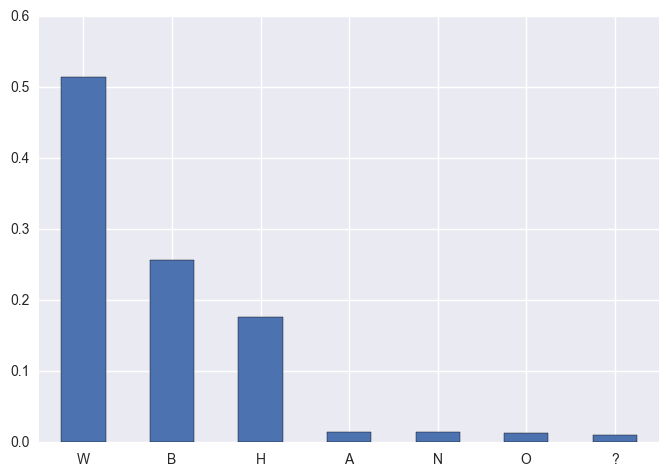

In [11]:
df_whole.race.fillna(value="?").value_counts(normalize=True).plot.bar(rot=0)
plt.show()

_For the subsequent Chi-Square tests_

_1) Whole group_

In [18]:
overall_group_proportions = df_whole.race.fillna(value="?").value_counts(normalize=True).tolist()
group_proportions_2015 = df2015.race.fillna(value="?").value_counts(normalize=True).tolist()

print "The values saved in the variable overall_group_proportions:"
print overall_group_proportions


The values saved in the variable overall_group_proportions:
[0.51439232409381663, 0.25639658848614072, 0.17590618336886993, 0.014925373134328358, 0.014925373134328358, 0.013326226012793176, 0.010127931769722815]


_2) Top 3 group_

In [70]:
t3_group_proportions = df_wh_top_3_races.race.fillna(value="?").value_counts(normalize=True).tolist()
t2_group_proportions_2015 = df2015_t2.race.fillna(value="?").value_counts(normalize=True).tolist()

print "The values saved in the variable t3_group_proportions:"
print t3_group_proportions

The values saved in the variable t3_group_proportions:
[0.54335585585585588, 0.27083333333333331, 0.1858108108108108]


__(1) Officer was charged__ (only available for 2015 data)

In [195]:
df2015[df2015.is_officer_charged].shape[0]

11

In [196]:
df2015[df2015.is_officer_charged].race.fillna(value="?").value_counts(normalize=True)

B    0.545455
W    0.454545
Name: race, dtype: float64

_Proportion with respect to whole race group in dataset_

In [197]:
(df2015[df2015.is_officer_charged].race.value_counts()
 /df2015.race.fillna(value="?").value_counts()).sort_values(ascending=False)

B    0.023256
W    0.009804
?         NaN
A         NaN
H         NaN
N         NaN
O         NaN
Name: race, dtype: float64

__(2) Unarmed__

In [198]:
df_whole[(df_whole["armed"]=="unarmed")].shape[0]

137

In [179]:
float(df_whole[(df_whole["armed"]=="unarmed")].shape[0])/float(df_whole.shape[0])

0.0730277185501066

In [37]:
df_whole[(df_whole["armed"]=="unarmed")].race.fillna(value="?").value_counts()

B    55
W    52
H    24
O     4
N     2
Name: race, dtype: int64

In [200]:
df_whole[(df_whole["armed"]=="unarmed")].race.fillna(value="?").value_counts(normalize=True)

B    0.401460
W    0.379562
H    0.175182
O    0.029197
N    0.014599
Name: race, dtype: float64

_Proportion with respect to whole race group in dataset_

In [66]:
(df_whole[(df_whole["armed"]=="unarmed")].race.fillna(value="?").value_counts()
/df_whole.race.fillna(value="?").value_counts()).sort_values(ascending=False)

O    0.160000
B    0.114345
H    0.072727
N    0.071429
W    0.053886
?         NaN
A         NaN
Name: race, dtype: float64

_Chi-Square test_

In [181]:
f_obs_2t3= [52, 55, 24] #frequencies of unarmed deceased by racial group

In [182]:
total_positives=df_wh_top_3_races[(df_wh_top_3_races["armed"]=="unarmed")].shape[0]

chisquare(f_obs_2t3,f_exp=([x * total_positives for x in t3_group_proportions]))

Power_divergenceResult(statistic=15.913273824225852, pvalue=0.00035032932681900147)

We can reject the null hypothesis.

__(2v2) Unarmed dead case not featuring an attack nor a violent crime suspect__

In [223]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["threat_level"]=="other") 
         & (df_whole["suspect"]==0)].shape[0]

60

In [224]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["threat_level"]=="other")
         & (df_whole["suspect"]==0)].race.value_counts()

B    24
W    23
H     9
O     3
N     1
Name: race, dtype: int64

In [225]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["threat_level"]=="other")
         & (df_whole["suspect"]==0)].race.value_counts(normalize=True)

B    0.400000
W    0.383333
H    0.150000
O    0.050000
N    0.016667
Name: race, dtype: float64

_Proportion with respect to whole race group in dataset_

In [226]:
(df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["threat_level"]=="other")
         & (df_whole["suspect"]==0)].race.value_counts()
/df_whole.race.fillna(value="?").value_counts()).sort_values(ascending=False)

O    0.120000
B    0.049896
N    0.035714
H    0.027273
W    0.023834
?         NaN
A         NaN
Name: race, dtype: float64

_Chi-Square test_

In [75]:
f_obs_2v2 = [23, 24, 9]

In [314]:
total_positives=df_wh_top_3_races[(df_wh_top_3_races["armed"]=="unarmed") 
         & (df_wh_top_3_races["threat_level"]=="other") 
         & (df_wh_top_3_races["suspect"]==0)].shape[0]

chisquare(f_obs_2v2, f_exp=([x * float(total_positives) for x in t3_group_proportions]))

Power_divergenceResult(statistic=7.1477817519268303, pvalue=0.028046515594389469)

We can reject the null hypothesis.

__(3) Unarmed fleeing felon case__ 

In [206]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES")].shape[0]

6

In [207]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES")].race.fillna(value="?").value_counts()

B    3
W    2
H    1
Name: race, dtype: int64

In [208]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES")].race.fillna(value="?").value_counts(normalize=True)

B    0.500000
W    0.333333
H    0.166667
Name: race, dtype: float64

_Proportion with respect to whole race group in dataset_

In [209]:
(df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES")].race.fillna(value="?").value_counts()
/df_whole.race.fillna(value="?").value_counts()).sort_values(ascending=False)

B    0.006237
H    0.003030
W    0.002073
?         NaN
A         NaN
N         NaN
O         NaN
Name: race, dtype: float64

__(3v2) Unarmed fleeing felon case not featuring an attack nor a violent crime suspect__

In [227]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES") 
         & (df_whole["threat_level"]=="other") 
         & (df_whole["suspect?"]==0)].shape[0]

2

In [228]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES") 
         & (df_whole["threat_level"]=="other") 
         & (df_whole["suspect?"]==0)].race.fillna(value="?").value_counts()

B    1
H    1
Name: race, dtype: int64

In [100]:
df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES") 
         & (df_whole["threat_level"]=="other") 
         & (df_whole["suspect?"]==0)].race.fillna(value="?").value_counts(normalize=True)

B    0.5
H    0.5
Name: race, dtype: float64

_Proportion with respect to whole race group in dataset_

In [102]:
(df_whole[(df_whole["armed"]=="unarmed") 
         & (df_whole["fleeing?"]=="YES") 
         & (df_whole["threat_level"]=="other") 
         & (df_whole["suspect?"]==0)].race.fillna(value="?").value_counts()
/df_whole.race.fillna(value="?").value_counts()).sort_values(ascending=False)

H    0.003030
B    0.002079
?         NaN
A         NaN
N         NaN
O         NaN
W         NaN
Name: race, dtype: float64

---

__EXTRA : (-1) dead who likely were perpetrating a violent crime__

In [212]:
df_whole[(df_whole["armed"]!="unarmed") 
         & (df_whole["threat_level"]=="attack")].shape[0]

1175

In [213]:
df_whole[(df_whole["armed"]!="unarmed") 
         & (df_whole["threat_level"]=="attack")].race.fillna(value="?").value_counts()

W    632
B    301
H    181
N     16
?     16
O     15
A     14
Name: race, dtype: int64

In [214]:
df_whole[(df_whole["armed"]!="unarmed") 
         & (df_whole["threat_level"]=="attack")].race.fillna(value="?").value_counts(normalize=True)

W    0.537872
B    0.256170
H    0.154043
N    0.013617
?    0.013617
O    0.012766
A    0.011915
Name: race, dtype: float64

_Proportion with respect to whole race group in dataset_

In [215]:
(df_whole[(df_whole["armed"]!="unarmed") 
         & (df_whole["threat_level"]=="attack")].race.fillna(value="?").value_counts()
/df_whole.race.fillna(value="?").value_counts()).sort_values(ascending=False)

?    0.842105
W    0.654922
B    0.625780
O    0.600000
N    0.571429
H    0.548485
A    0.500000
Name: race, dtype: float64

_Chi-Square test_

In [185]:
f_obs_x=[632, 301, 181]

In [315]:
total_positives= float(df_wh_top_3_races[(df_wh_top_3_races["armed"]!="unarmed") 
         & (df_wh_top_3_races["threat_level"]=="attack")].shape[0])

chisquare(f_obs_x,f_exp=([float(x) * total_positives for x in t3_group_proportions]))

Power_divergenceResult(statistic=4.4436616136860767, pvalue=0.10841044843519552)

We can't reject the null hypothesis.

---

__Results__

What we can say:

1) the kind of cases that are often second-guessed by the public make a very small proportions of all the killings, not only by the "unarmed" variable (which has been shown already by journalists working with the source dataset). This one makes but 7.3% of the whole (The proportion of unarmed shot people decreased from 9.28% to 5.08% from 2015 to 2016, but the difference is not statistically significant). The groups I defined myself examined captured limited numbers. That was to be expected since they build on the already marginal "unarmed" group. Their size is however too small for application of the Chi-Square test.

2) By all but one of the proxies used, there are notable differences between races in the dataset as to the proportion of cases falling in my discriminant groups, and Black people stand before any single racial group when looking at the proportion of the whole group in the dataset. In other words: _"for the Black people __that were killed__"_ a greater proportion than other races were so in _circumstances for which justifiability would have needed investigation_, by my chosen proxies.
However, only two cases had frequencies large enough for my statistical test (Chi-Square). For the "unarmed cases" group, we can reject the null hypothesis of no difference with p-value = 0.01 and for the "unarmed cases not featuring an attacking person or a violent crime suspect". 

__Discussion__

As a reminder, the implications regarding probability of justifiability that can be derived using these factors, as there are still a plethora of possible circumstances that would argue against racial disadvantage: so far, I have not separated. For example, some "unarmed" shot people were actually collateral victims because of being in cars with people who they were armed and had a confrontation with police. All these factors need be accounted for. 

The general limitations I encountered with my proxies lend weight to the argument that for reliable tools to investigate 'justifiability' of police killings and their interaction with other factors as racial profiles, information available to the public like news data is not enough, and therefore the American authorities (FBI), who only can explore ways of obtaining the needed information from the police agencies, are the ones with a role to play.

I must stress that I am JUST reporting the p-value using the Chi-Square test of variable independence. That was the one statistical test I found for categorical data, but I have yet to research its theoretical weight. I have nevertheless, as stated, sticked by the advice that the frequencies have a particular minimum (equal to 5)).

Looking forward, the proxies that could not be statistically assessed can be as we get data for more years. 

### Hierarchical Clustering

I applied clustering techniques to the variables relative to behaviour of the people shot ("flee", "weapon_groups" and "threat-level"). The "flee" variable values is thus explained:

- "Not fleeing" are cases that did not feature a chase at any point.
- "Car" & "Foot" are cases where the shot person tried to flee from police at some point, either by car or by foot
- "Other" are cases where the question is irrelevant or makes no sense.

The "threat-level" variable values are thus explained:

- the "attack" value corresponds to cases where the individuals had already 1) fired shots, 2) brandished a gun or 3) started an attack on a person with a weapon or their bare hands.
- "other" groups all other cases (they mention at least two distinct groups within (one of whom includes people holding non-firearm weapons) in their story, but they do not provide this information in the data put at our disposition).
- "undetermined" are cases where the Washington Post was unable to determine the circumstances of the shootings because of limited information or ongoing investigations

Clustering techniques use distance to form clusters. For categorical data, alternatives are needed. After exploring different alternatives. I believe hierarchical clustering that will re-use the distance function presented in the paper should be a more effective way to appreciate similarity.

---

__Data transformation__

In [ ]:
#I define groups here rather than modifying the data in the dataset to be able to revert if wanted

In [43]:
df_clust_ = pd.concat([df2015.drop("is_officer_charged", axis=1), df2016], ignore_index=True)

In [44]:
def weapon_groups(weapon):
    if weapon in ["guns and explosives", "gun and knife", "hatchet and gun"]:
        weapon="gun"
    elif weapon=="motorcycle":
        weapon="vehicle"
    elif weapon=="in vehicle with criminal":    
        weapon="unarmed"
    elif weapon in ["baseball bat", "hammer", "Taser", "metal pipe", "screwdriver", "crossbow", "rock", "baton", "metal pole", "brick"                               
,"flashlight","carjack","pole","chain","flagpole","pipe","hand torch","metal object","metal rake","piece of wood","bean-bag gun"
,"contractor's level","beer bottle"]:
        weapon="blunt object"
    elif weapon not in ["gun", "knife", "unarmed", "vehicle","toy weapon", "undetermined", "unknown weapon"]:
        weapon="other"
    return weapon

df_clust_["weapon_groups"]=df_clust_["armed"].apply(weapon_groups)

In [45]:
df_clust=df_clust_.drop(["age", "full_state","date_in_year","armed", "description", "city", "name", "month", "day_of_month", "fleeing?", "suspect?", "race"], axis=1)

In [46]:
df_clust.head()

,flee,threat_level,weapon_groups
0,Not fleeing,attack,gun
1,Not fleeing,attack,gun
2,Not fleeing,other,unarmed
3,Not fleeing,attack,toy weapon
4,Not fleeing,attack,other


__Forming linkage matrix__

In [285]:
from sklearn import metrics
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import LabelEncoder

In [286]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

In [287]:
#scipy pdist requires label-encoded X values
X=df_clust.copy()
le = LabelEncoder()
for x in X.columns:
    X[x]=le.fit_transform(X[x])

In [288]:
#Basic Dissimilarity measure function, modeled on k-modes

def diss(row1, row2):
    diss=0
    for i1,i2 in zip(row1, row2):
        if i1!=i2:
            diss+=1
        else:
            pass
    return diss 
    
my_metric = pdist(X, (lambda u,v: diss(u,v)))

---------------

In [289]:
Z = linkage(my_metric,'complete') 
#works with single linkage as well,
#but not with 'average linkage'

In [290]:
c, coph_dists = cophenet(Z, my_metric)
c

0.77833885098270117

__What clusters do we have?__

Hierarchical clustering leaves the final choice of clusters to the researcher, so exploration is as per interest.
At a relatively low level of dissimilarity (1, the maximum being 4), I identified 18 clusters with non-homogenous sizes. Their number is quite apprehensible, so they are worth looking into.

In [292]:
max_dist = 1.0 #gives groups with 1 difference (so 2 variables in common)
clusters = fcluster(Z, max_dist, criterion='distance') 


In [293]:
df_hier_clust=df_clust.copy()
df_hier_clust["clusters_max_dist_1"]=clusters
#then would get count for each of the clusters with value_counts() & inspect
#clusters with a chosen minimum count of samples

In [319]:
print "we have {} clusters with a dissimilarity of 1 only.".format(df_hier_clust["clusters_max_dist_1"].nunique())

we have 18 clusters with a dissimilarity of 1 only.


I only retain clusters making a large proportion of the total dataset (keeping in mind that proportions in our dataset are of more insterest than they would have been for a mere sample). 

In [295]:
df_hier_clust["clusters_max_dist_1"].value_counts(normalize=True).head(10)

11    0.458422
12    0.201493
17    0.146055
8     0.048507
7     0.031450
10    0.028785
16    0.022921
2     0.010128
9     0.008529
4     0.008529
Name: clusters_max_dist_1, dtype: float64

In [296]:
groups=pd.groupby(df_hier_clust, by="clusters_max_dist_1")


Here are these notable groups:

In [297]:
for cluster in df_hier_clust["clusters_max_dist_1"].value_counts().head(3).index:
    print "cluster {}".format(cluster)
    print groups.get_group(cluster).drop("clusters_max_dist_1", axis=1).describe(), "\n"

cluster 11
               flee threat_level weapon_groups
count           860          860           860
unique            1            1             9
top     Not fleeing       attack           gun
freq            860          860           629 

cluster 12
               flee threat_level weapon_groups
count           378          378           378
unique            1            1             9
top     Not fleeing        other         knife
freq            378          378           159 

cluster 17
       flee threat_level weapon_groups
count   270          274           274
unique    3            1             1
top     Car       attack           gun
freq    122          274           274 



- 1) The first group (labelled cluster 11 above) is comprised of cases where no chase was involved at any point and the shot people evidenced the highest level of threat "attack". It makes at least 40% of the dataset. Within this cluster 73% had guns, 10% had knifes.

- 2) The second group (labelled cluster 12 above) is comprised of cases where no chase was involved at any point and the shot people did not evidence the highest level of threat. It makes at least 20% of the dataset. Within this cluster 42% had knifes, 19% guns, 11% other non-blunt weapons, 9% were unarmed.

- 3) The third group (labelled cluster 17 above) is comprised of cases where the shot people did evidence the highest level of threat, and all had guns. It makes at least 14% of the dataset. Within this cluster, an equal proportion of 45% were trying to flee by car or foot, and the rest of the cases have missing values with respect to that aspect (10%). There is no case in this cluster where it has been confirmed the person did not try to flee from police at any point.

Further steps missing: 

- State distribution of groups: showing these clusters on a map with the American states

#### Discussion

Together, these groups make at least 74% of the whole Washington Post dataset of shot people. Their uniformity would make them worth further looking into as they could inform on the nature of cases where police shoot to kill (armed robberies? car stops? etc.). I plan to do that to complete this project, but as far as this report for marking is concerned, I have not done it.

__*A more representative dissimilarity metric?*__

I thought of modifying the dissimilarity measure to account for category frequency for an attribute (the more frequent a category, the more important the dissimilarity implied by a mismatch). 

However, the basic form I have used is objective, whereas using category frequency gives intra-dataset similarity only (e.g. two cases with "race" == White need not be less similar than two cases with "race" == Black). If one where to develop this work, they could use data on demographics of those groups.